# Milestone 2 - Analysis part

## Imports

In [1]:
# let's import the libraries
import gc
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from ipywidgets import interactive
import statsmodels.formula.api as smf

In [2]:
# import the data 
# this dataframe contains at each row a rating. The information of the brewery and user are merge to each rating
df_ratings = pd.read_pickle("data_merged.pkl")
df_ratings.head()

,abv,appearance,aroma,beer_id,brewery_id,date,overall,palate,rating,style,...,user_id,review,brew_location,brew_name,brew_nbr_beers,user_nbr_ratings,user_name,user_joined,user_location,user_nbr_reviews
0,5.0,2.0,2.0,410549,3198,2016-04-26 10:00:00,2.00,2.0,2.0,Lager,...,175852,False,Gabon,Sobraga,3,1890,Manslow,2012-05-20 09:59:28,Poland,0
1,5.2,2.0,1.5,105273,3198,2017-02-17 11:00:00,2.00,2.0,1.9,Lager,...,442761,False,Gabon,Sobraga,3,89,MAGICuenca91,2017-01-10 10:59:12,Spain,0
2,5.2,3.0,1.5,105273,3198,2016-06-24 10:00:00,1.25,2.0,1.6,Lager,...,288889,False,Gabon,Sobraga,3,169,Sibarh,2013-11-16 10:59:12,Poland,0
3,5.2,4.0,1.5,105273,3198,2016-01-01 11:00:00,1.25,1.0,1.5,Lager,...,250510,False,Gabon,Sobraga,3,3371,fombe89,2013-03-22 10:59:12,Spain,0
4,5.2,2.0,2.0,105273,3198,2015-10-23 10:00:00,1.75,2.0,1.9,Lager,...,122778,False,Gabon,Sobraga,3,13043,kevnic2008,2011-02-02 10:59:12,Germany,0


In [3]:
print('Columns of df_ratings:')
df_ratings.columns

Columns of df_ratings:


Index(['abv', 'appearance', 'aroma', 'beer_id', 'brewery_id', 'date',
       'overall', 'palate', 'rating', 'style', 'taste', 'user_id', 'review',
       'brew_location', 'brew_name', 'brew_nbr_beers', 'user_nbr_ratings',
       'user_name', 'user_joined', 'user_location', 'user_nbr_reviews'],
      dtype='object')

In [4]:
print('length of df_ratings')
len(df_ratings)

length of df_ratings


15515106

In [5]:
print("nbr of lines with missing values in df_ratings")
print(len(df_ratings[df_ratings.isna().any(axis=1)]))

nbr of lines with missing values in df_ratings
6652158


In [6]:
print("columns with missing values in df_ratings")
print(list(df_ratings.loc[:,df_ratings.isna().any(axis=0)].columns))

columns with missing values in df_ratings
['abv', 'appearance', 'aroma', 'overall', 'palate', 'taste', 'brew_location', 'brew_name', 'user_name', 'user_joined', 'user_location']


In [7]:
# Get the brewery data of beeradvocate and ratebeer
# This dataframe: df_breweries is studied later in this report

# paths
folderRB = 'Data/RateBeer'
folderBA = 'Data/BeerAdvocate'
folderM = 'Data/matched_beer_data'
fileBrew = '/breweries.csv'

# type to use
colType = {'nbr_beers': np.int32, 'id': np.int32, 'name' : 'string[pyarrow]', 'location': 'string[pyarrow]'}

# import de csv's
dfRB = pd.read_csv(folderRB+fileBrew, encoding='utf-8', dtype=colType)
dfBA = pd.read_csv(folderBA+fileBrew, encoding='utf-8', dtype=colType)
dfM = pd.read_csv(folderM+fileBrew, header=1, encoding='utf-8') # correspondance id2=> id1

# handling the data to get them in a proper form
df_breweries = dfBA.set_index('id').drop(dfM['id'])
brew_shift = dfRB.id.max()
df_breweries.index += brew_shift
df_breweries = pd.concat([dfRB.set_index('id'), df_breweries])

for j, c in df_breweries.location.items():
    if len(c) > 50:
        t = c.split('<', 1)[0]
        if t!='United States':
            t = 'United States, ' + t
        df_breweries['location'][j] = t


df_breweries.location = df_breweries.location.astype('category')
# Dataframe of the breweries
df_breweries = df_breweries.reset_index()

# delete the no more used dataframes
del dfRB, dfBA, dfM
gc.collect();

## Date clustering

For temporal analysis, rating date are handled. For this purpose, the seasonal periods (spring, summer...), the month periods (january, february...) and a column 'period' which proposes a flexible choice of data clustering i.e. of period (eg. the year of the rating date). The latter is coded in the following.

In [8]:
def cluster_date(df,dMonth=0, dDay=0):
    '''
    desc : The aim of this function is to add an additional column to the input dataframe that contains the index of the cluster
           in which a rating was written
    :param df: dataframe from which we want to extract the time period cluster
    :param dMonth: number of monthes that constitute the cluster of month
    :param dDay: number of days that constitute the cluster of days
    :return: The input dataframe with an additional column (period), it represent the cluster in which a rating is
    '''
    
    #init the new column
    df['period'] = 0
    
    #define the time t0
    current_time = df.date.min()
    
    #define the number of period after the transformation
    dTime = np.timedelta64(0, 'D'); #fake value to have the good type
    if dDay!=0:
        dTime = np.timedelta64(dDay, 'D')
    else:
        dTime = np.timedelta64(dMonth, 'M')
        
    print(f"Length of the temporal clusters : {dTime}")
    I_max = round((df.date.max()-df.date.min())/dTime)
    print(f"Number of different temporal periods (clusters) : {I_max}")
    
    
    #transform the rating dates and add the transformed column at the end of the dataframe
    for i in range(I_max+1):
        mask = ((df["date"]>=current_time) & (df["date"]<current_time+dTime))
        df.loc[mask,'period'] = i
        current_time = current_time + dTime
    return df

In [9]:
# df_ratings_date contains the different clusters for the rating date 
# as the date column of df_ratings has no missing values, all ratings should 
# get a period, month and season 
# add the period 
df_ratings_date = cluster_date(df_ratings,dMonth=12)

Length of the temporal clusters : 12 months
Number of different temporal periods (clusters) : 21


**above temporal cluster important to remind for the following : column 'period' determines a year when the rating was posted**
**the year 0 corresponds to 1996** 

In [10]:
def season(date):
    '''
    desc : 
    :param date: exact date
    :return: season in which the date is
    '''
    if (date.month == 12 or 1 <= date.month <= 2):
        return "winter"   
    elif (3 <= date.month <= 5):
        return "spring" 
    elif (6 <= date.month <= 8):
        return "summer"
    elif (9 <= date.month <= 11):
        return "fall"

In [11]:
#dictionnary month to numbers
dict_month_to_numbers = {'January': 1, 'February': 2, 'March': 3, 'April':4, 'May':5, 'June':6, 'July':7, 
                         'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
dict_season_to_numbers = {'spring': 1, 'summer': 2, 'fall': 3, 'winter':4}

In [12]:
# add the month
df_ratings_date["month"] = df_ratings_date.date.apply(lambda x: x.month_name())
# add the season 
df_ratings_date["season"] = df_ratings_date.date.apply(lambda x: season(x))

In [13]:
df_ratings_date.head()

,abv,appearance,aroma,beer_id,brewery_id,date,overall,palate,rating,style,...,brew_name,brew_nbr_beers,user_nbr_ratings,user_name,user_joined,user_location,user_nbr_reviews,period,month,season
0,5.0,2.0,2.0,410549,3198,2016-04-26 10:00:00,2.00,2.0,2.0,Lager,...,Sobraga,3,1890,Manslow,2012-05-20 09:59:28,Poland,0,19,April,spring
1,5.2,2.0,1.5,105273,3198,2017-02-17 11:00:00,2.00,2.0,1.9,Lager,...,Sobraga,3,89,MAGICuenca91,2017-01-10 10:59:12,Spain,0,20,February,winter
2,5.2,3.0,1.5,105273,3198,2016-06-24 10:00:00,1.25,2.0,1.6,Lager,...,Sobraga,3,169,Sibarh,2013-11-16 10:59:12,Poland,0,19,June,summer
3,5.2,4.0,1.5,105273,3198,2016-01-01 11:00:00,1.25,1.0,1.5,Lager,...,Sobraga,3,3371,fombe89,2013-03-22 10:59:12,Spain,0,19,January,winter
4,5.2,2.0,2.0,105273,3198,2015-10-23 10:00:00,1.75,2.0,1.9,Lager,...,Sobraga,3,13043,kevnic2008,2011-02-02 10:59:12,Germany,0,19,October,fall


In [14]:
print("Size of df_ratings_date : ")
len(df_ratings_date)

Size of df_ratings_date : 


15515106

In [15]:
print("nbr of lines with missing values in file df_ratings_date")
len(df_ratings_date[df_ratings_date.isna().any(axis=1)])

nbr of lines with missing values in file df_ratings_date


6652158

In [16]:
print("columns with missing values in file df_ratings_date")
list(df_ratings_date.loc[:,df_ratings_date.isna().any(axis=0)].columns)

columns with missing values in file df_ratings_date


['abv',
 'appearance',
 'aroma',
 'overall',
 'palate',
 'taste',
 'brew_location',
 'brew_name',
 'user_name',
 'user_joined',
 'user_location']

As the length and number of missing values of df_ratings and df_ratings_date are the same and date, period, month and season columns have no missing values, the period clustering of the rating date has been performed well !

## First analysis of brewery data

This first analysis on brewery was conducted in the first time to discover and better understand the data. The given results depicted in the following sub-chapters are not supposed to be directly used in the project, but more as a complement of its spine.

##### First step

In [17]:
# breweries dataframe
df_breweries.head()

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3


In [18]:
# check the nbr of breweries
print("number of breweries")
len(df_breweries)

number of breweries


32666

In [19]:
print('number of different names')
len(df_breweries.name.unique())

number of different names


31039

In [20]:
print('number of different id')
len(df_breweries.id.unique())

number of different id


32666

**=> Id of breweries are unique but not the names !!**

In [21]:
print("number of country in file of breweries")
len(df_breweries.location.unique())

number of country in file of breweries


282

In [22]:
# check for missing values
print("nbr of lines with missing values in file of breweries")
len(df_breweries[df_breweries.isna().any(axis=1)])

nbr of lines with missing values in file of breweries


0

##### Distribution of breweries across the countries

As our project is interested on a spatial-temporal approach, a first point is to get a first insight of the distribution of the breweries for each country

Number of countries in the plot:


109

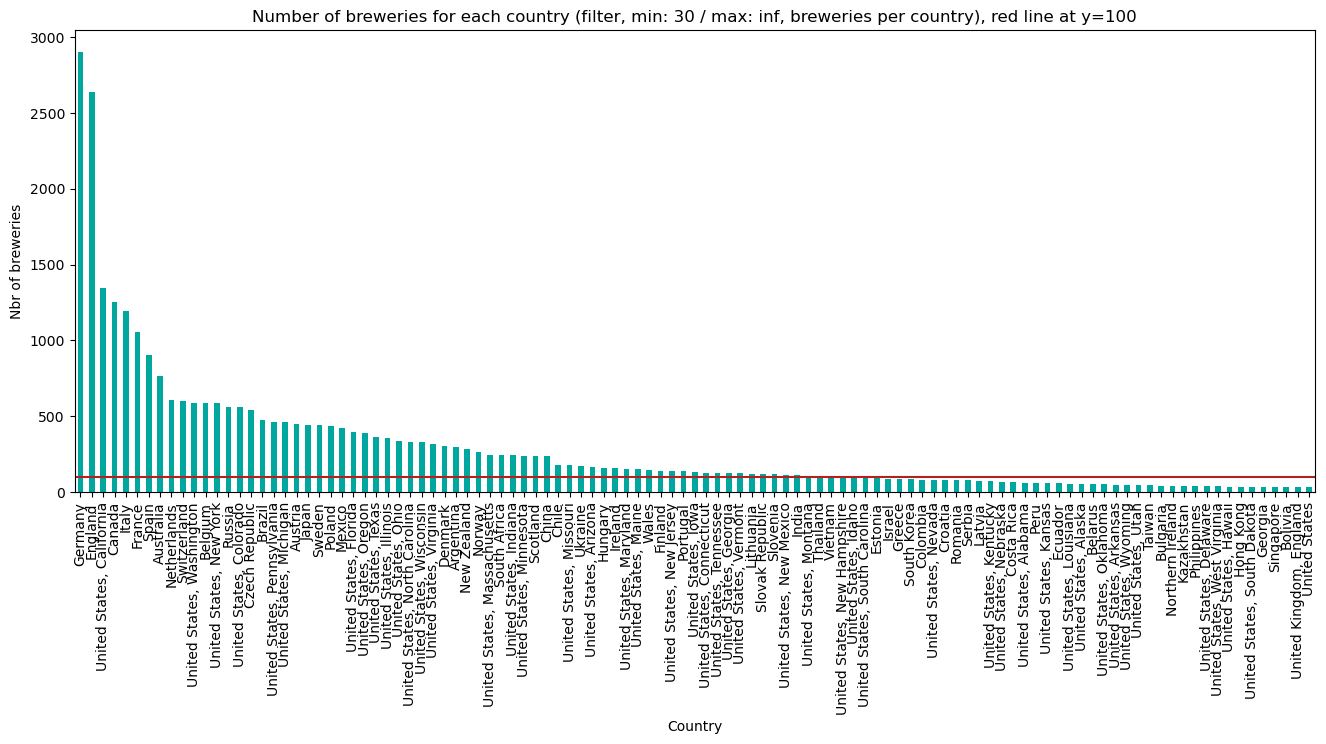

In [23]:
# plot number of breweries for each country

# parameters to slide on the window analysis and horizontal line to analyse the graph
nb_of_min_brew_per_country = 30
nb_of_max_brew_per_country = np.inf
horizontal_line = 100

# plot the data 
# data : for each country we take the count of the unique breweries id
df_breweries_location = df_breweries.groupby('location')['id'].nunique()
df_breweries_location = df_breweries_location.loc[(df_breweries_location.values>=nb_of_min_brew_per_country) &
                                                  (df_breweries_location.values<=nb_of_max_brew_per_country)].sort_values(ascending=False)
ax = df_breweries_location.plot.bar(rot=90, figsize=(16, 6),
                                    title="Number of breweries for each country (filter, min: " \
                                         + str(nb_of_min_brew_per_country) + " / max: " + str(nb_of_max_brew_per_country)\
                                         + ", breweries per country), red line at y=" + str(horizontal_line), color='#00A79F')
ax.set_xlabel("Country")
ax.set_ylabel("Nbr of breweries")
ax.axhline(y = horizontal_line, color = '#B51F1F', linestyle = '-')
print("Number of countries in the plot:")
len(df_breweries_location)

About seventy countries/states in the US have more than 100 breweries. This corresponds mainly to American, European and Asian countries. About 160 countries have less than 20 breweries. These are from all continents. Then, we are also interested in the distribution of the breweries regarding the ratings.

In [24]:
# plot sum and avg number of ratings for the breweries for each country

# prepare the data
# data : we take for each country the sum of the ratings of the breweries and the mean of the ratings per brew.
df_breweries_ratings = df_ratings.loc[df_ratings['brew_location'].notna()] #remove nan in the location
df_breweries_ratings = df_breweries_ratings.groupby(['brew_location', 'brewery_id'])['date'].agg('count')
df_breweries_ratings = df_breweries_ratings.loc[df_breweries_ratings != 0]
df_breweries_ratings = df_breweries_ratings.groupby(['brew_location']).agg(['sum','mean'])  
df_breweries_ratings.head()

,sum,mean
brew_location,,
Abkhazia,28,9.333333
Albania,755,39.736842
Algeria,84,7.636364
Andorra,306,76.500000
Angola,118,29.500000


Number of countries in the plot:
43


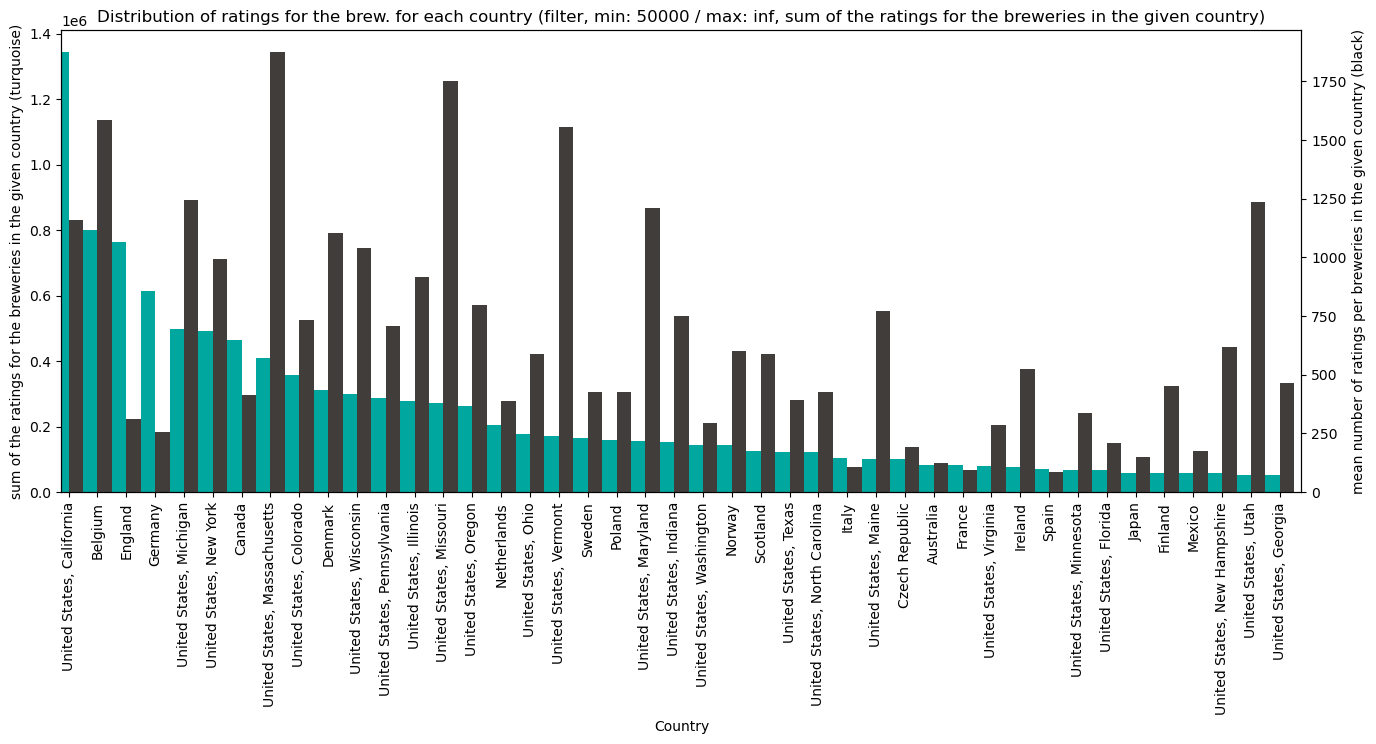

In [25]:
# plot the data - nb. re-run the cell before
# parameters to slide the window analysis
nb_of_min_rating = 50000
nb_of_max_rating = np.inf

# filter according the parameters on the sum of ratings of the breweries of the considered country
df_breweries_ratings = df_breweries_ratings.loc[(df_breweries_ratings['sum']>=nb_of_min_rating) &
                                                (df_breweries_ratings['sum']<=nb_of_max_rating)] \
                                           .sort_values(ascending=False, by='sum')

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

df_breweries_ratings['sum'].plot(kind='bar', ax=ax, position=1, color = '#00A79F')
df_breweries_ratings['mean'].plot(kind='bar', ax=ax2, position=0, color = '#413D3A')

ax.set_xlabel("Country")
ax.set_ylabel('sum of the ratings for the breweries in the given country (turquoise)')
ax2.set_ylabel('mean number of ratings per breweries in the given country (black)')

ax.set_title("Distribution of ratings for the brew. for each country (filter, min: " \
             + str(nb_of_min_rating) + " / max: " + str(nb_of_max_rating)\
             + ", sum of the ratings for the breweries in the given country)")

print("Number of countries in the plot:")
print(len(df_breweries_ratings))
plt.show()

The left axis corresponds to the sum of the ratings for the breweries in the given country (turquoise), the right axis is the mean number of ratings per breweries in the given country (black).


It can be seen that about 40 countries/states in the USA have a rating sum for breweries between 50,000 and 1.4 million. This corresponds mainly to American and European countries. About two hundred countries have this number between 0 and 10000. These are from all continents. An interesting observation is that the right axis decreases not regularly with the left axis, so there are sometimes countries with quite significant 'mean number of ratings per breweries in the given country' given a moderate or low 'sum of the ratings for the breweries in the given country'. For these countries, it means that they may have important breweries even if the left axis is moderate or low, and it would be interesting to consider them.

##### Some brewery features analysis across time

After looking at spatial distribution of breweries, some brewery features are analysed across time in the following. Here is our approach which consisted in studying some characteristics of the breweries to better understand the dataset with time. An analysis on a choosen time period type across years (cf. period given in 'Date clustering') is proposed. Nb other period types analysis have been performed (eg. per month, per season) but are not presented here as we have chosen to move towards an analysis based primarily on years. Nevertheless, these other possibilities are not discarded to maybe support the backbone of our project.

In [26]:
# type of period clustering analysis
clustering_period = 'period' # 'None', 'season', 'month' or 'period' (i.e. according period column of df_ratings_date)
make_one_rating_period = False
if clustering_period == None :
    clustering_period = 'period'
    make_one_rating_period = True


# First get the useful data from df_ratings_date 
# Data: For a rating : we take the considered period, the brewery Id, the style of the beer and the beer id 
df_brewery_beer = df_ratings_date[[clustering_period,'brewery_id','style','beer_id']]
df_brewery_beer = df_brewery_beer.rename(columns={clustering_period: 'rating_period'})
if make_one_rating_period == True :
    df_brewery_beer.rating_period = 1
df_brewery_beer['nb_rating'] = 1 #column for the number of rating
df_brewery_beer['style'] = df_brewery_beer['style'].astype(str)

size_df_brewery_beer = len(df_brewery_beer)
print("Size of df_brewery_style (before removing nan of user_location) : {:.0f}".format(size_df_brewery_beer))
# one line is one rating in the following df_brewery_beer
df_brewery_beer.head()

Size of df_brewery_style (before removing nan of user_location) : 15515106


,rating_period,brewery_id,style,beer_id,nb_rating
0,19,3198,Lager,410549,1
1,20,3198,Lager,105273,1
2,19,3198,Lager,105273,1
3,19,3198,Lager,105273,1
4,19,3198,Lager,105273,1


In [27]:
# group by the considered period of the rating and the brewery 
# to get a list of the unique styles of each brewery for each period = combinaison of rated styles !
# the number of unique beer_id and the count of ratings of each brewery for each period
df_brew_period = df_brewery_beer.groupby(['rating_period', 'brewery_id']).agg({'style':'unique', 
                                                                               'beer_id':'nunique', 
                                                                               'nb_rating':'count'})
df_brew_period['style'] = df_brew_period['style'].apply(lambda x: set(x))
df_brew_period.head()

style  \
rating_period brewery_id                                                      
0             32279                                              {Pale Ale}   
1             32255                                                 {Stout}   
              32257       {IPA, Lager, Porter, Stout, Specialty Beer, St...   
              32258                      {IPA, Specialty Beer, Belgian Ale}   
              32259                                     {Stout, Bitter Ale}   

                          beer_id  nb_rating  
rating_period brewery_id                      
0             32279             1          1  
1             32255             1          1  
              32257             7          7  
              32258             3          3  
              32259             2          2

In [28]:
# list of rating period in df_brew_period
list_rating_period = list(df_brew_period.reset_index().rating_period.sort_values().unique())
# adaptation with dictionnary for month and season for displaying the slider with numbers
if clustering_period == 'month':
    # list of period
    list_rating_period = list(map(dict_month_to_numbers.get, list_rating_period))
elif clustering_period == 'season':
    # list of period
    list_rating_period = list(map(dict_season_to_numbers.get, list_rating_period))
list_rating_period

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [29]:
def get_unique_sets(l):
    '''
    return a list of the unique sets of a list
    :param l: list of the sets to handle
    :return: list of the unique sets
    '''
    unique_sets = []
    for s in l:
        if s not in unique_sets:
            unique_sets.append(s)
    return unique_sets

In [30]:
# plotting function
def histo_brewery(time_period):
    '''
    plot histograms on brewery features : beer id, nb rating and combinaison of style
    :param time_period: time period to display (as a number)
    :return: histograms
    '''
    fig,ax = plt.subplots(1, 3, figsize=(16, 5))
    
    # histogram on beer id
    df_brew_period.xs(time_period).plot.hist(column='beer_id', logy = True, bins = 1000, ax = ax[0], legend=False,
                                             xlim=(0,1.1*df_brew_period.xs(time_period).beer_id.max()), color='#007480')
    ax[0].set_xlabel('Number of different rated beer of a brewery')
    ax[0].set_ylabel('Number of breweries')
    ax[0].set_title('Different rated beer of a brewery')
    
    # histogram on nb_rating
    df_brew_period.xs(time_period).plot.hist(column='nb_rating', logy = True, bins=50, ax = ax[1], legend=False,
                                             xlim=(0,1.1*df_brew_period.xs(time_period).nb_rating.max()),color='#B51F1F')
    ax[1].set_xlabel('Number of ratings given to a brewery')
    ax[1].set_ylabel('Number of breweries')
    ax[1].set_title('Number of ratings given to a brewery')
    
    # histogram on combinaison style
    data_list = []
    for i in get_unique_sets(df_brew_period.xs(time_period)['style']) :
        data_list.append(df_brew_period.xs(time_period)['style'].tolist().count(i))
    ax[2].hist(data_list, log=True, bins=50, color='#413D3A')
    ax[2].set_xlim(0,1.1*np.max(data_list))
    ax[2].set_xlabel('Number of brewery with a given combinaison of rated styles')
    ax[2].set_ylabel('Number of combinaison of styles')
    ax[2].set_title('Combinaison of styles')    

interactive_histo_brewery = interactive(histo_brewery, time_period=(min(list_rating_period), max(list_rating_period), 1))

In [31]:
interactive_histo_brewery

interactive(children=(IntSlider(value=10, description='time_period', max=20), Output()), _dom_classes=('widget…

example for the period: 12


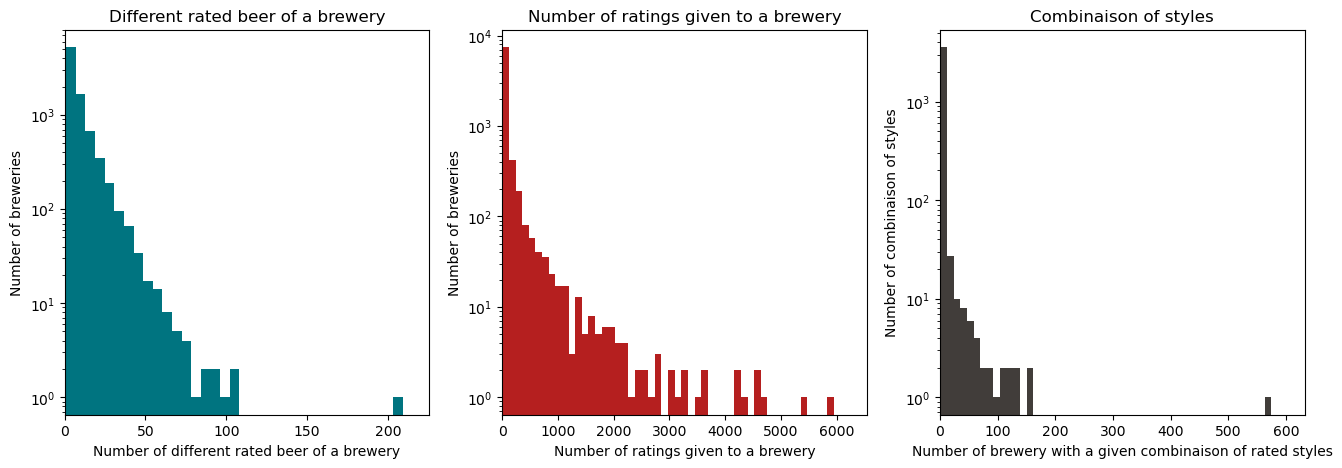

In [32]:
# here is an example for a given period
# (if the widget is not displayed for milestone 2 correction)
time_period_example = 12
print('example for the period: ' + str(time_period_example))
histo_brewery(time_period_example)

* 'Different rated beer of a brewery' and 'number of ratings given to a brewery' :
    - They have both the aspect of a heavy tailed distribution. In both cases, the frequency of higher number of different rated beer of a brewery and of higher number of ratings given to a brewery is increasing with time. The latter can be due to the increase in popularity of the websites and maybe also to the change in popularity of some breweries. The evolution of the left graph can be also impacted by the popularity of the website as more beer will be noted but maybe also to a change of the brewery number of proposed beer to the public... that could be to investigate.
* 'Combinaison of styles' :
    - A combinaison of rated style is used to describe a set of beer style(s) (eg. {'Ale', 'Lager'} or {'Stout', 'Sake','Dark ale'}) that have been rated for one brewery,in this case in this graph for one period. 
    - It has also the aspect of a heavy tailed distribution. So there are a lot of different breweries with different combinaison of rated style.
    - It would be interesting to study the evolution of this combinaison of rated style in more detail, how some evolves, what are the more present styles or set of styles ...
    - There is a very little increase of frequency of higher number of brewery with a given combinaison of rated styles with increasing periods; impact of the expansion of the websites or trend of the breweries to tend to get same sets of styles ?
    
    
Recall : one period is one year, the period 0 is 1996

These graphs are interesting and more could be said about them. This will be the aim of the next milestone if these questions are choosen to be investigated (reminder: these are not supposed to be the main questions of our project)

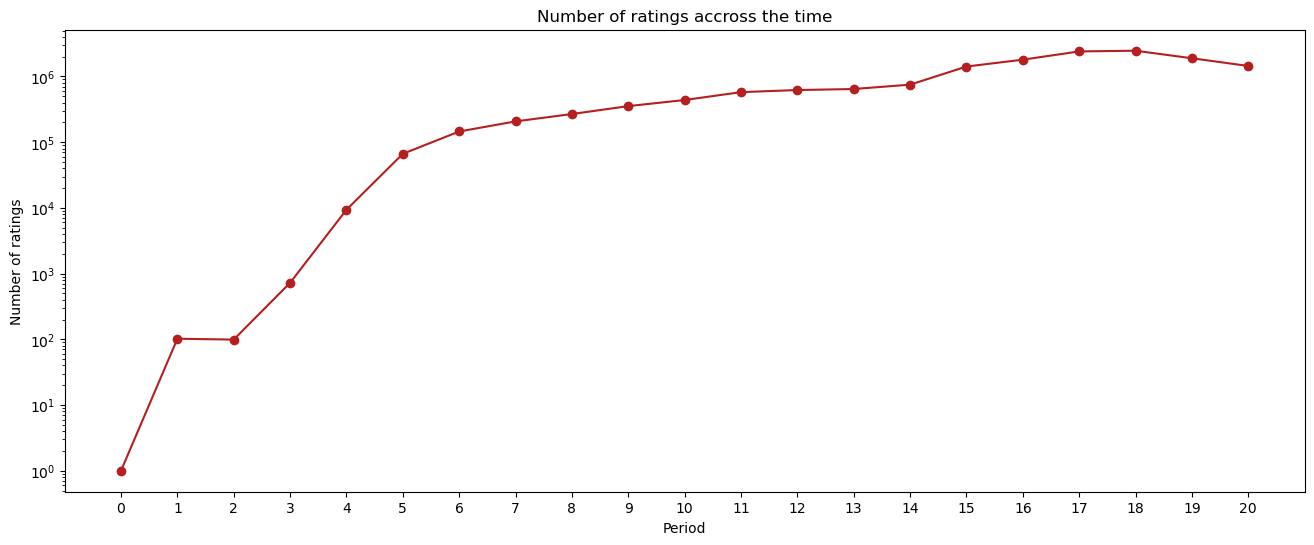

In [33]:
# plot the timeline of the number of ratings
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
df_brew_period.reset_index().groupby('rating_period')['nb_rating'].agg('sum').plot.line(ax = ax, logy=True, 
                                                                                        color='#B51F1F',marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Number of ratings')
ax.set_title('Number of ratings accross the time')
plt.xticks(np.arange(min(list_rating_period),max(list_rating_period)+1 , step=1))
plt.show()

With the latter subplots, it was seen that the number of ratings seems to be very low for the first periods. Indeed, it is observed here that there is a log increase with time of the number ratings and we need to wait period 5, to get the step of 100'000 ratings for one period. This should be mainly due to the expension of the websites. (recall: one period is one year, the period 0 is 1996)

## Study of the export of beer

This chapter is used for the study of the export of beers (cf. readme)

Now let's combine spatial and time considerations. The aim of this part is to provide a dataframe to have for a certain brewery location the number or proportion of ratings rated at a certain user location, across time.

The result of this chapter is the dataframe ```df_brew_user_loc_cross```:

* this is a multiindexed row dataframe with on the columns: brewery locations and on the rows: user locations and the periods considered. The values are the number of ratings or the number of ratings normalized on the sum of ratings for the corresponding brewery location at each period if respectively norm_brewery_location is not activated or is activated

* min_filter_brew_loc_activated performs a filtering. This parameter is rather used for displaying purpose and can be set to false when all the data are needed. Diplaying was useful for this first step to check the good implementation of the dataframe and to get a visual sense of this data.

* for each period the columns and rows are made to be the same. This involve a bigger dataframe however a regular shape through the periods can be useful when handling the table. The future will tell us if this is needed or not. At this step it was better to do something proper and latter if some implementation are not needed it is easy to remove them (easy to remove features afterwards than to add).

In [34]:
## Parameter

# if filter activated : 
min_filter_brew_loc_activated = True
# minimum number of ratings for a brewery location (at a period) else this series is set to zero
min_sum_brew_loc = 3000 
# minimum value of at least one cell needed to keep a user location (at a period) else this series is set to zero
min_cell_user_loc = 0.05 # it is a nbr of ratings or a normalized one if resp. norm_brewery_location not activated 
# or activated. the latter should be kept quite low, its aim is to remove the very negligeable data
# nb. if a row or a column is zero for each period it won't be kept; if not for each period, it displays a zero line

# if activated : normalization on the brewery location series for each country (at a period)
norm_brewery_location = True

# type of period clustering 
clustering_period = 'period' # 'season', 'month' or 'period' (i.e. according period column of df_ratings_date)

In [35]:
# First get the useful data from df_ratings_date and removing the nan user_location
# data : For each period, we take the user location and the brewery location
df_brew_user_location = df_ratings_date[[clustering_period,'user_location','brew_location']]
df_brew_user_location = df_brew_user_location.rename(columns={clustering_period: 'rating_period'})
df_brew_user_location['nb_rating'] = 1 #column for the number of rating

size_brew_user_loc_before_clean = len(df_brew_user_location)
print("Size of df_brew_user_location (before removing nan) : {:.0f}".format(size_brew_user_loc_before_clean))

Size of df_brew_user_location (before removing nan) : 15515106


In [36]:
# remove nan of df_brew_user_location of the column user_location and brew_location
df_brew_user_location = df_brew_user_location.loc[(df_brew_user_location['user_location'].notna()) &
                                                  (df_brew_user_location['brew_location'].notna())]
df_brew_user_location.head()

,rating_period,user_location,brew_location,nb_rating
0,19,Poland,Gabon,1
1,20,Spain,Gabon,1
2,19,Poland,Gabon,1
3,19,Spain,Gabon,1
4,19,Germany,Gabon,1


In [37]:
size_brew_user_loc_after_clean = len(df_brew_user_location)
print("Size of df_brew_user_location (after removing nan) : {:.0f}".format(size_brew_user_loc_after_clean))
print("This represents a removal of {:.4f}% of the original data".format(100*(size_brew_user_loc_before_clean-size_brew_user_loc_after_clean)/size_brew_user_loc_before_clean))

Size of df_brew_user_location (after removing nan) : 10782613
This represents a removal of 30.5025% of the original data


It is a significant amount of data that is removed, we have noticed that and do not want to hide that. The "mousquetaire" in charge of the data handling will further investigate to understand why. Then, if needed correct the data handling, else study what are the removed data to correct the potential bias generated. This was discovered too late to perform this properly for milestone 2 deadline and will be thus done for milestone 3. In any case, there is still about 10mio of data now which is assumed to be enough to go on with our method to develop the df_brew_user_loc_cross dataframe.

In [38]:
print("nbr of lines with missing values in file df_brew_user_location")
len(df_brew_user_location[df_brew_user_location.isna().any(axis=1)])

nbr of lines with missing values in file df_brew_user_location


0

In [39]:
# list of rating_period in df_brew_user_location
list_rating_period = list(df_brew_user_location.rating_period.sort_values().unique())
print("Rating period considered :")
list_rating_period

Rating period considered :


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [40]:
# df_brew_user_loc_cross : for each period, nbr of ratings for a brewery location and user location
# the data will be crossed in this dataframe for each period
df_brew_user_loc_cross = pd.DataFrame()
for period in list_rating_period :
    # crosstab, user location on row / brew location on column
    df_cross_period = pd.crosstab(df_brew_user_location.loc[df_brew_user_location.rating_period == period]['user_location'],\
                                  df_brew_user_location.loc[df_brew_user_location.rating_period == period]['brew_location'])
    #df_cross_period = df_cross_period.fillna(0) # set to zero couple user vs brew location that do not exist
    df_cross_period.fillna(0, inplace = True)
    
    # if min_filter_brew_loc_activated activated 
    if min_filter_brew_loc_activated :
        mask_brew = df_cross_period.sum(axis=0)>=min_sum_brew_loc
        df_cross_period = df_cross_period.loc[:, mask_brew]
        mask_user = df_cross_period.sum(axis=1)>0 # remove the user location that are no more matched with a brew loc
        df_cross_period = df_cross_period.loc[mask_user, :]

    # if norm_brewery_location
    if norm_brewery_location :
        df_cross_period = df_cross_period/df_cross_period.sum(axis=0)
        df_cross_period = df_cross_period.fillna(0)

    # if min_filter_brew_loc_activated activated
    if min_filter_brew_loc_activated :
        mask_user = (df_cross_period>=min_cell_user_loc).any(axis=1)
        df_cross_period = df_cross_period.loc[mask_user, :]
        
    # add the period info in the index
    df_cross_period = pd.concat([df_cross_period], keys=[period], names=['period'])
    
    # add the missing new columns to df_brew_user_loc_cross 
    brew_to_add = list(set(df_cross_period.reset_index().columns) - set(df_brew_user_loc_cross.columns))
    df_brew_user_loc_cross = pd.concat([df_brew_user_loc_cross,pd.DataFrame(0,index=df_brew_user_loc_cross.index,columns=brew_to_add)],axis=1)
    
    # fill df_brew_user_loc_cross with the new period
    df_brew_user_loc_cross = pd.concat([df_brew_user_loc_cross, df_cross_period.reset_index()],axis=0)
    df_brew_user_loc_cross = df_brew_user_loc_cross.replace(np.nan,0) # to fill the nan of the col of df_cross_period not in df_brew_user_loc_cross
    
# use the period and user_location as index
df_brew_user_loc_cross = df_brew_user_loc_cross.set_index(['period', 'user_location'])

# remove null columns
mask_brew = df_brew_user_loc_cross.sum(axis=0)>0
df_brew_user_loc_cross = df_brew_user_loc_cross.loc[:, mask_brew]

# if a period is not presented : create an empty one with zeros
period_to_add = list(set(list_rating_period) - set(df_brew_user_loc_cross.index.get_level_values(level=0).unique()))
period_present = list(set(list_rating_period) - set(period_to_add))
random_user = df_brew_user_loc_cross.xs(period_present[0]).index[0]
index_to_add = pd.MultiIndex.from_tuples([(x, random_user) for x in period_to_add], names=('period', 'user_location'))
dataframe_to_add = pd.DataFrame(0,index=index_to_add, columns=df_brew_user_loc_cross.columns)
df_brew_user_loc_cross = pd.concat([df_brew_user_loc_cross, dataframe_to_add],axis=0)
print("Period(s) with no data : ")
print(period_to_add)

# add user location to the period such that all period have the same ones
set_user_location = set(df_brew_user_loc_cross.index.get_level_values(level=1).unique())
for period in list_rating_period :
    user_to_add = list(set_user_location - set(df_brew_user_loc_cross.xs(period).index.unique()))
    index_to_add = pd.MultiIndex.from_tuples([(period, x) for x in user_to_add], names=('period', 'user_location'))
    dataframe_to_add = pd.DataFrame(0,index=index_to_add, columns=df_brew_user_loc_cross.columns)
    df_brew_user_loc_cross = pd.concat([df_brew_user_loc_cross, dataframe_to_add],axis=0)

# order the data on the indexes
df_brew_user_loc_cross = df_brew_user_loc_cross.sort_index(axis=0).sort_index(axis=1)

# check shape of df_brew_user_loc_cross
print('shape of df_brew_user_loc_cross : ')
df_brew_user_loc_cross.shape

Period(s) with no data : 
[0, 1, 2, 3, 4]
shape of df_brew_user_loc_cross : 


(1260, 59)

In [41]:
print("nbr of lines with missing values in file df_brew_user_loc_cross")
len(df_brew_user_loc_cross[df_brew_user_loc_cross.isna().any(axis=1)])

nbr of lines with missing values in file df_brew_user_loc_cross


0

In [42]:
# get the data for the display
# for the display, a slider is used and need numbers for the period so an adjustment is done
# for the period indexes. This is done on a copy of df_brew_user_loc_cross in order to not alter this latter 
df_brew_user_loc_cross_display = df_brew_user_loc_cross.copy()
list_period_display = list_rating_period

In [43]:
# adaptation with dictionnary for month and season for displaying the slider with numbers
if clustering_period == 'month':
    # df
    df_brew_user_loc_cross_display = df_brew_user_loc_cross_display.reset_index()
    df_brew_user_loc_cross_display.period = df_brew_user_loc_cross_display.period.map(dict_month_to_numbers)
    df_brew_user_loc_cross_display = df_brew_user_loc_cross_display.set_index(['period', 'user_location'])
    
    # list of period
    list_period_display = list(map(dict_month_to_numbers.get, list_period_display))
elif clustering_period == 'season':
    # df
    df_brew_user_loc_cross_display = df_brew_user_loc_cross_display.reset_index()
    df_brew_user_loc_cross_display.period = df_brew_user_loc_cross_display.period.map(dict_season_to_numbers)
    df_brew_user_loc_cross_display = df_brew_user_loc_cross_display.set_index(['period', 'user_location'])
    
    # list of period
    list_period_display = list(map(dict_season_to_numbers.get, list_period_display))

In [44]:
print('List of period for displaying')
list_period_display

List of period for displaying


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [45]:
# heat map brewery location vs user location for a certain period
# Pay caution that some cell names are not overlap !
vmax_heatmap_location_brew_user = df_brew_user_loc_cross_display.max().max()
def plotting_location_brew_user(time_period):
    '''
    plot the heatmap of numbers/proportions of rating for brewery location vs user location
    :param time_period: time period to display (as a number)
    :return: heatmap
    '''
    plt.figure(figsize = (15,12))
    fig = sns.heatmap(df_brew_user_loc_cross_display.xs(time_period),square=False, 
                      cmap=sns.color_palette("magma_r", as_cmap=True), 
                      vmin=0, vmax=vmax_heatmap_location_brew_user)
    if not norm_brewery_location :
        fig.set(title='Number of ratings at period: ' \
                + str(time_period) + ' (Brewery location vs user location)')
    else :
        fig.set(title='Proportion of ratings regarding the brewery location at period : ' \
                + str(time_period) + ' (Brewery location vs user location)')
    fig.set_xlabel('Brewery location', fontsize=10)
    fig.set_ylabel('User location', fontsize=10)
    
interactive_plot_loc_brew = interactive(plotting_location_brew_user, time_period=(min(list_period_display), max(list_period_display), 1))

In [46]:
# print Summary of used parameters
print("Summary of used parameters")

print("- Clustering period method : " + clustering_period)

if min_filter_brew_loc_activated:
    print("- Filter activated with : min_sum_brew_loc : {:.0f} and min_cell_user_loc : {:.3f} ".format(min_sum_brew_loc, min_cell_user_loc))
else :
    print("- Filter not activated")
    
if norm_brewery_location :
    print("- Normalization on brewery location at each period : activated")
else :
    print("- Normalization on brewery location at each period : not activated")

Summary of used parameters
- Clustering period method : period
- Filter activated with : min_sum_brew_loc : 3000 and min_cell_user_loc : 0.050 
- Normalization on brewery location at each period : activated


#### Data available

In [47]:
# list of periods in df_brew_user_loc_cross 
print('List of period in df_brew_user_loc_cross :')
list_rating_period

List of period in df_brew_user_loc_cross :


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [48]:
# DataFrame : df_brew_user_loc_cross
print('df_brew_user_loc_cross :')
df_brew_user_loc_cross.sample(3)

df_brew_user_loc_cross :


,,Australia,Austria,Belgium,Brazil,Canada,Czech Republic,Denmark,England,Estonia,Finland,...,"United States, Pennsylvania","United States, South Carolina","United States, Tennessee","United States, Texas","United States, Utah","United States, Vermont","United States, Virginia","United States, Washington","United States, Wisconsin",Wales
period,user_location,,,,,,,,,,,,,,,,,,,,,
7,Australia,0.561515,0.0,0.028011,0.0,0.007362,0.000000,0.00000,0.060151,0.0,0.0,...,0.003331,0.0,0.0,0.000000,0.0,0.005937,0.0,0.001528,0.004114,0.0
12,"United States, Oregon",0.005817,0.0,0.009592,0.0,0.005650,0.004537,0.00181,0.012209,0.0,0.0,...,0.015214,0.0,0.0,0.011804,0.0,0.011487,0.0,0.053292,0.011519,0.0
9,Poland,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0


#### Display the data available

In [49]:
# widget with a slider for time
interactive_plot_loc_brew

interactive(children=(IntSlider(value=10, description='time_period', max=20), Output()), _dom_classes=('widget…

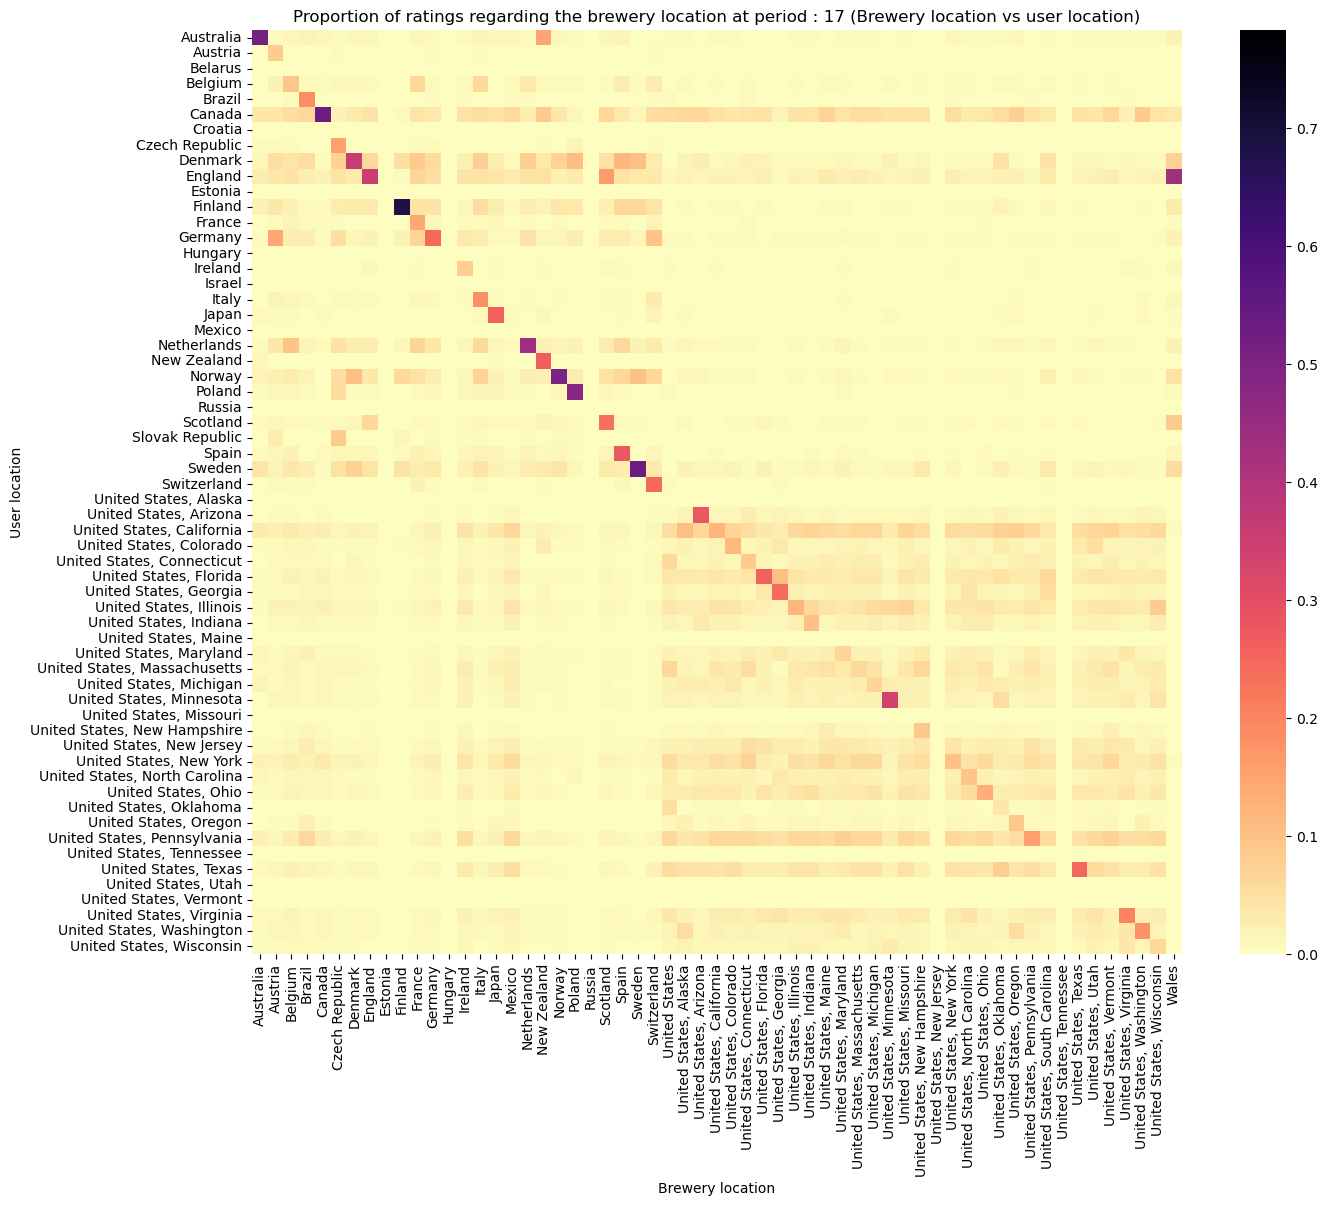

In [50]:
# an example of display (if the widget is not displayed for milestone 2 corretion)
time_period_example = 17
plotting_location_brew_user(time_period_example)

A period in this analysis corresponds to a year and the period 0 corresponds to 1996. The columns are the brewery location of the ratings and the rows the user location. The values here are choosen to be the proportion of ratings during a year of a given brewery location rated in a certain user location i.e. the number of ratings are normalized on the sum of ratings of the considered brewery location. The table seems to be good implemented as a marked sort of diagonal is present meaning that beers are rated more generally by user in the same country than the brewery which seems reasonable. Then, for example, a significant amount of beers of breweries from New Zealand and Wales are respectively rated in Australia and England which seems also reasonable. The right down marked square region shows that beers from USA are a lot rated in USA which is also acceptable. More observation/investigation will be done during the next milestone as this dataframe is an important point for the project. Here the point of the observations was to make a check and give a sense of the dataframe.

## Analysis : Beers distribution over all 23 main styles

The aim of this part is to provide an overview of the different types of beers, to see if there are categories that are not well represented, or if the ratings are anormally distributed.

In [51]:
df_beer = df_ratings_date.groupby(by = 'style')["rating"].agg(["count", "mean"])\
                     .sort_values(by = "count",ascending = False)

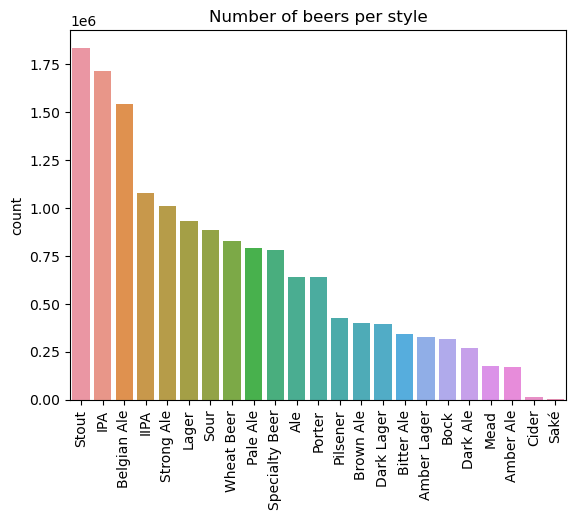

In [52]:
ax = sns.barplot(x = np.array(df_beer.index),
                 y = df_beer.loc[:,"count"])
ax.set_xticklabels(np.array(df_beer.index), rotation=90)
plt.title("Number of beers per style")
plt.show()

The orders of magnitude remain more or less constant for all types of beers. Except for the cases of cider and sake, it seems that the number of data is sufficient to be studied more deeply

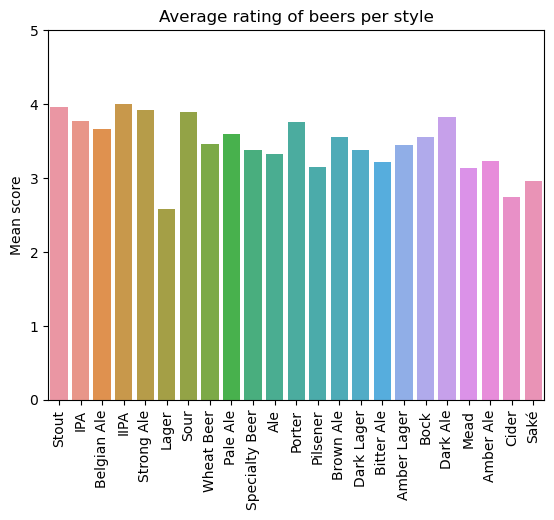

In [53]:
ax = sns.barplot(x = np.array(df_beer.index),
                 y = df_beer.loc[:,"mean"])
ax.set_xticklabels(np.array(df_beer.index), rotation=90)
plt.title("Average rating of beers per style")
plt.ylim([0,5])
plt.ylabel("Mean score")
plt.show()

The average rating score per style is bounded between 2/5 and 4/5. There is no obvious outlyer in our ratings. We can go on with these datas!

## Analysis :  Indentify trends over time

The aim of this part is to identify trends over time. If some are found, it will be used later in the simulation to emulate the evolution of the chosen beer in the real beer market that is implicitly depicted in the provided dataset

### What is the evolution of the relation between the market and the attributes of all the beer styles over time ?

The following plot identifies the evolution of the ratings of the 4 different attributes (aroma, appearance, palate, taste) over time in a given country for all styles of beer
NB: It should be an interactive plot, but for the sake of simplicity in Milestone 2, the resulting plot is only displayed in Canada

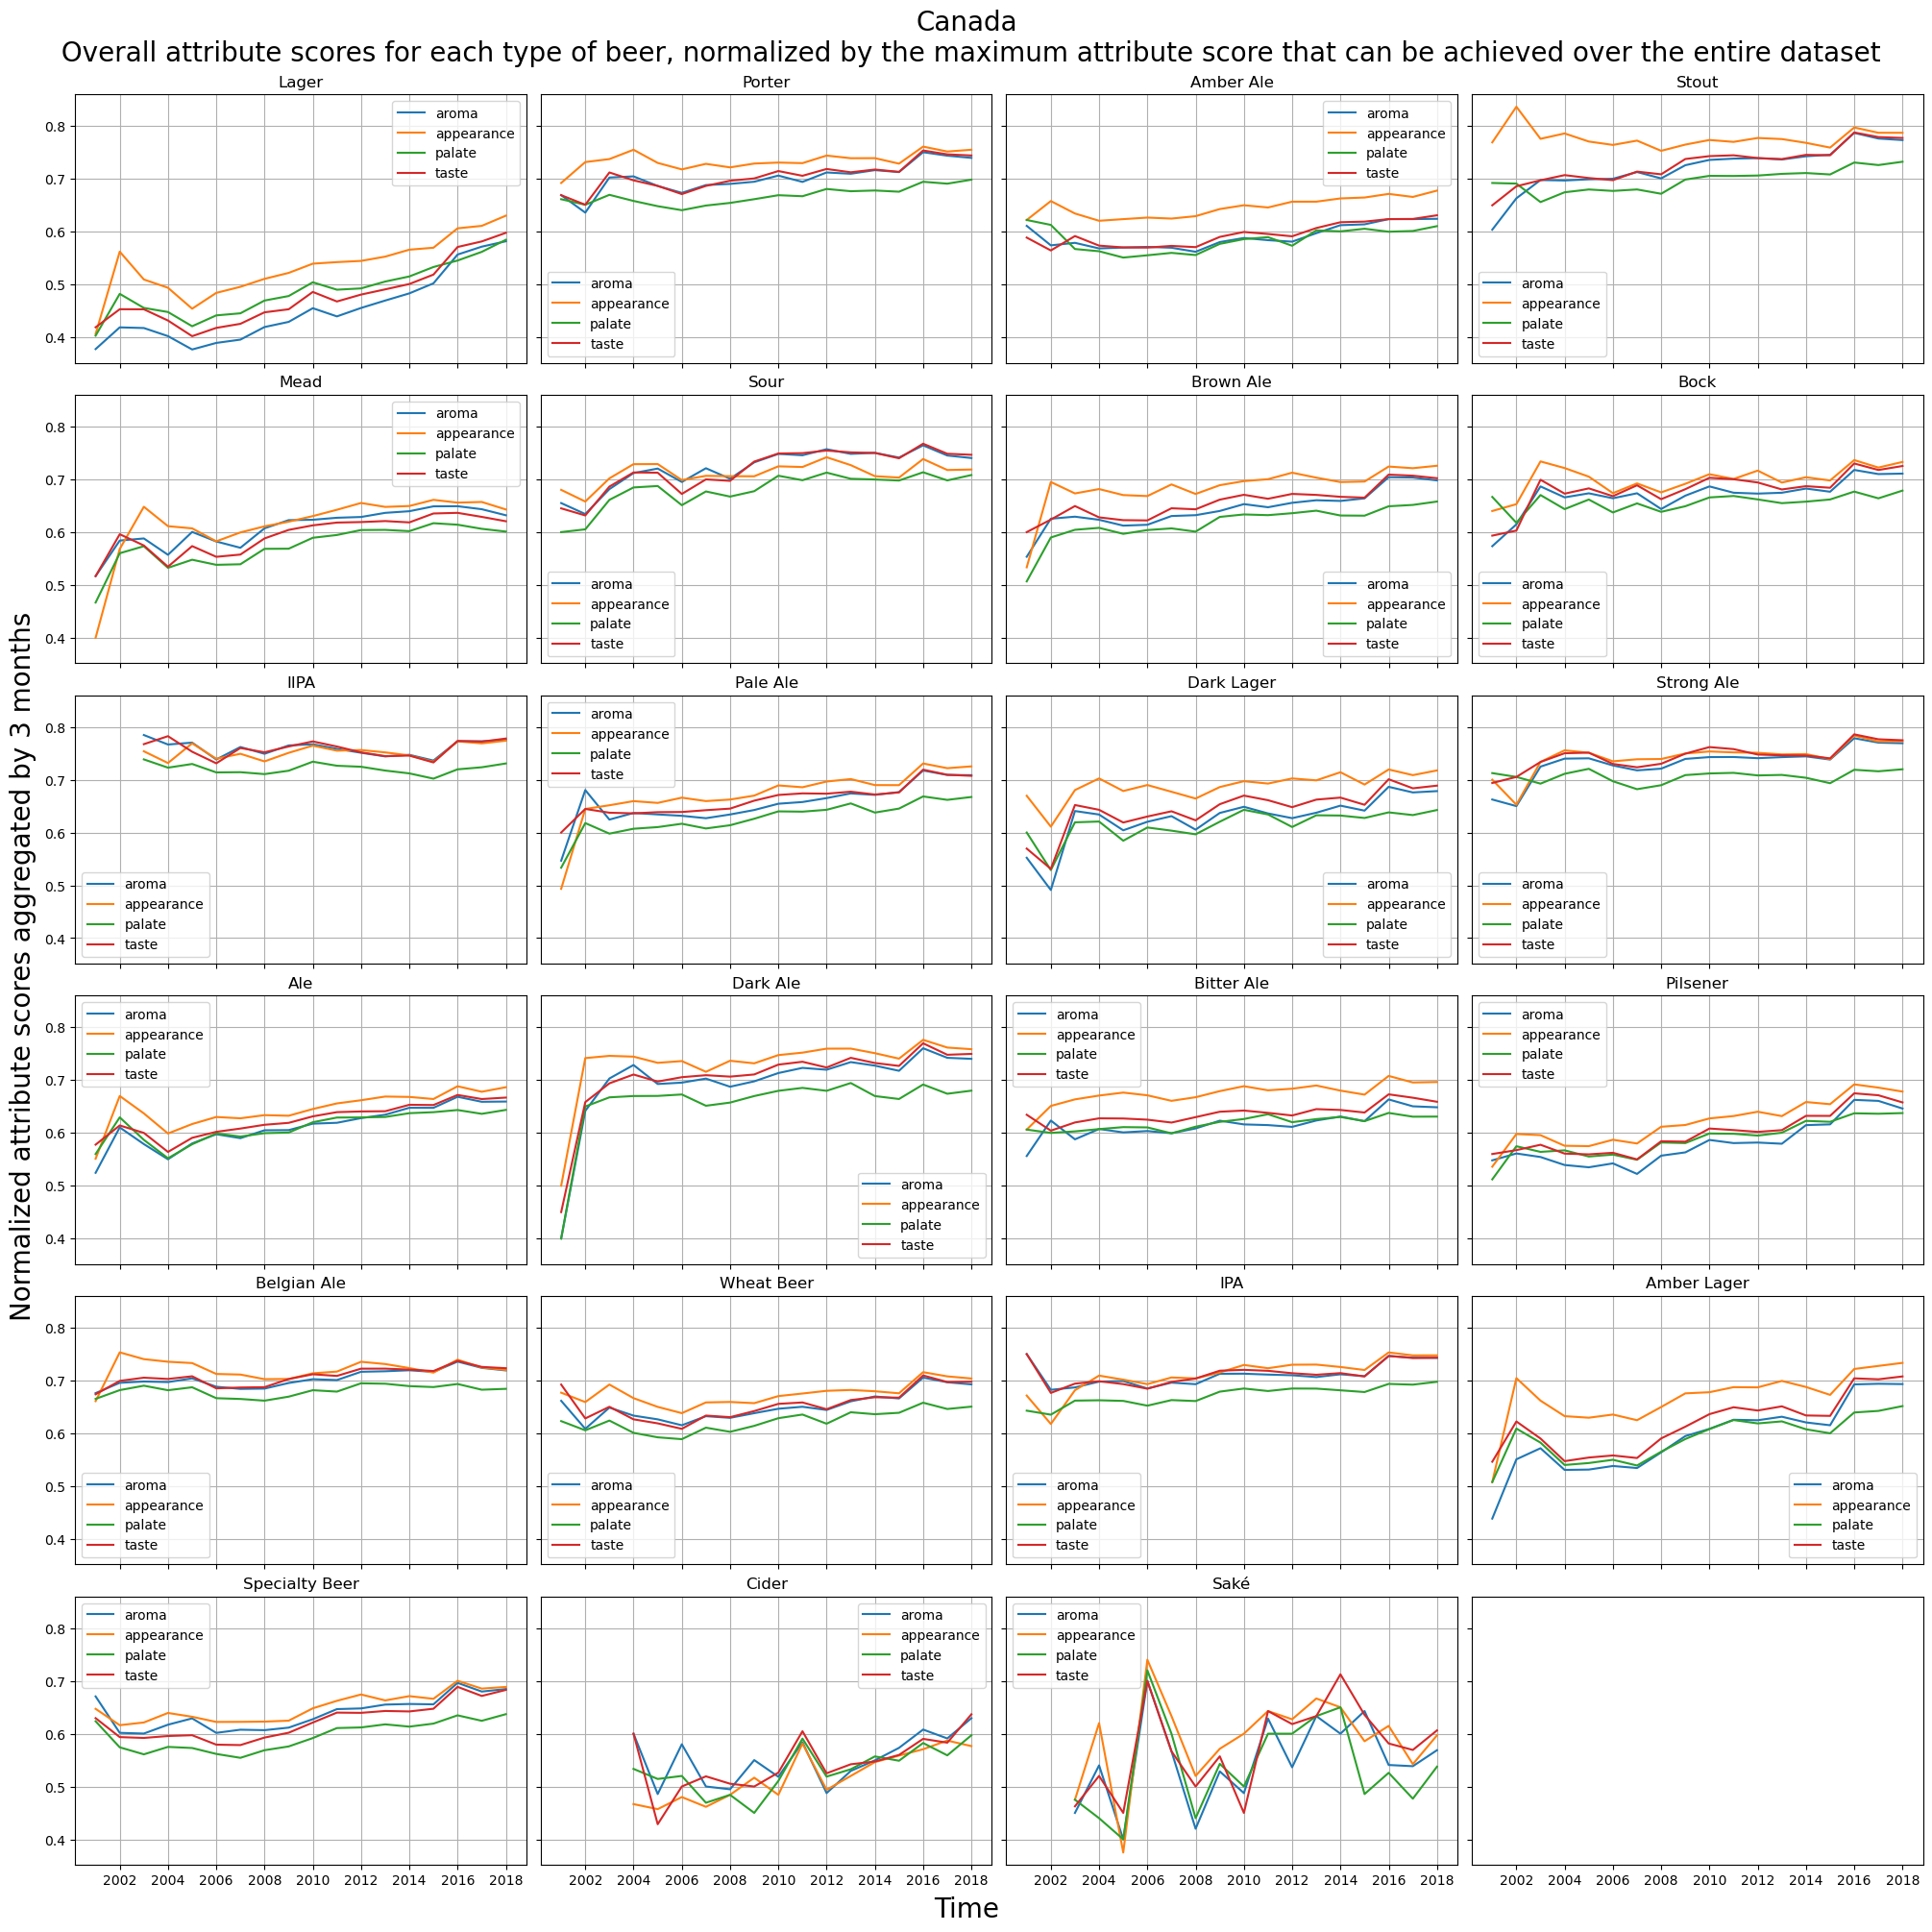

In [54]:
def plot_attributes_trends(country="Canada"):
    
    #Beer attributes evolution (for a given country)
    fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(20, 20), sharey = True, sharex = True, layout="constrained")
    i=0
    j=0
    for style in set(df_ratings_date["style"]):
        
        #normalization factors: (min/max normalization cf.lecture week 8)
        max_appearance = df_ratings_date["appearance"].max()
        max_aroma = df_ratings_date["aroma"].max()
        max_palate = df_ratings_date["palate"].dropna().astype("int").max()
        max_taste = df_ratings_date["taste"].max()
        
        sbplt = ax[j,i%4]
        df = df_ratings_date[(df_ratings_date["user_location"]==country)&(df_ratings_date["style"]==style)]\
                    .sort_values('date')\
                    .groupby(pd.Grouper(key='date', axis=0, freq='Y'))\
                    .apply(lambda x : pd.Series({
                             'mean_rating' : x["rating"].mean(),
                             'nb_rating' : x["rating"].count(),
                             'mean_appearance' : x["appearance"].mean()/max_appearance,
                             'mean_aroma' : x["aroma"].mean()/max_aroma,
                             'mean_palate': x["palate"].dropna().astype("int").mean()/max_palate,
                             'mean_taste' : x["taste"].mean()/max_taste
                            }))
        xval = [x for x in df.index.date]
        
        #Beer attributes
        sbplt.plot(xval, df["mean_aroma"], label = "aroma")
        sbplt.plot(xval, df["mean_appearance"], label = "appearance")
        sbplt.plot(xval, df["mean_palate"], label = "palate")
        sbplt.plot(xval, df["mean_taste"], label = "taste")
        sbplt.set_title(style)
        #sbplt.set_xticks([])
        sbplt.grid()
        sbplt.legend(loc='best')
        i+=1
        if i%4==0:
            j+=1    

    plt.suptitle(f"{country}\n Overall attribute scores for each type of beer, normalized by the maximum attribute score that can be achieved over the entire dataset"\
                 ,fontsize = 20, ha = "center")
    fig.supylabel("Normalized attribute scores aggregated by 3 months", fontsize = 20)
    fig.supxlabel("Time", fontsize = 20)

plot_attributes_trends("Canada")
#beer_attributes_plot = interactive(plot_attributes_trends, country= sorted(df_ratings['user_location'].dropna(axis=0).unique()));
#beer_attributes_plot

Unfortunately, it seems difficult to identify trends for the different beer styles (this result is general for all countries). The only beer styles that vary significantly are cider and sake. However, we were able to observe beforehand that these two styles did not have enough data to be included in this in-depth analysis

## Can the evolution of the number of consumers over time be weighted by the average score that the beer will receive?

This chapter corresponds to the chapter : Study of the beer's ratings distribution (cf.readme)

Can we define a probability of obtaining an overall score according to the style of beer that the bewer has chosen, the date on which he decides to release the beer on the market and according to the country in which the user decides to develop his business? 

In [55]:
#get the min and max score of the dataset, to have an invariant plot layout
min_overall_score = min(set(df_ratings_date["rating"]))
max_overall_score = max(set(df_ratings_date["rating"]))


def hist_score(country="Canada", style = "Belgian Ale", period = 15):
    mask = ((df_ratings_date["user_location"]==country)&(df_ratings_date["style"]==style)&(df_ratings_date["period"]==period))
    n = plt.hist(df_ratings_date[mask]["rating"],bins=np.arange(min_overall_score-0.5,max_overall_score+0.5, 0.5)\
                 , range = (1,5), color="#00A79F", edgecolor='black', alpha=0.6\
                 , weights = np.ones(len(df_ratings_date[mask]["rating"]))/len(df_ratings_date[mask]["rating"]))
    plt.xlabel("Overall score")
    plt.ylabel("Probability")
    plt.title(f"Probability to obtain an overall score in {country} for a {style} at time period {period}")
    plt.xticks(np.arange(min_overall_score,max_overall_score+0.5, 0.5))
    plt.show()
    proba = n[0]
    return proba

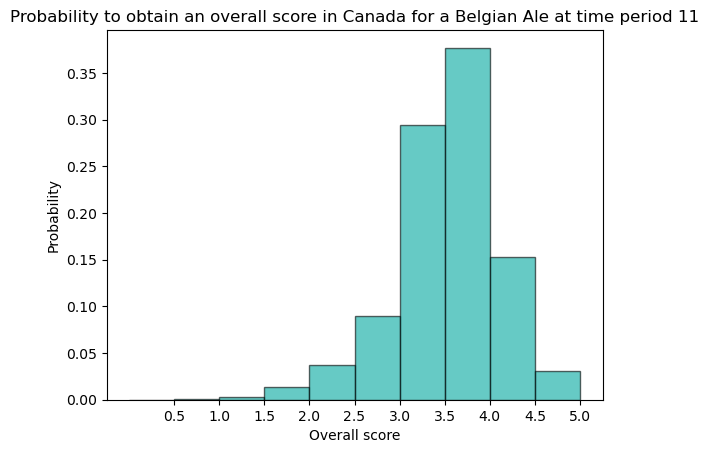

The coefficients of the probability distribution are : 
[0.         0.00064007 0.00298699 0.0140815  0.03712396 0.09003627
 0.29443141 0.37700021 0.15276296 0.03093663]
Check that it is indeed a probability : sum = 1.0000000000000884


In [56]:
array_proba = hist_score(country="Canada", style="Belgian Ale", period=11)
print(f"The coefficients of the probability distribution are : \n{array_proba}")
print(f"Check that it is indeed a probability : sum = {array_proba.sum()}")

Great, we have found a density function, that seems to have a good gaussian shape ! (can be generalized for all beer styles and all countries)

The goal of this graph is to show that we can create a probabilistic model, that can predict the overall score of a beer depending on the country in which the latter will be developped, and depending on the style of the beer. This study is performed to return a score, that is used to ponderate the evolution of the popularity of a beer (described in the next chapter)

# Evolution of the popularity of beer

This chapter corresponds to the chapter: Study of the popularity of beer (cf.readme)

For this part, we first create a Dataframe to facilitate the analysis.

NB: We only consider years after 2000, which is the period 5 of our yearly analysis. This seems to be a reasonable assumption since we saw in a previous graph that the websites were not sufficiently developed before this date.

In [57]:
df_porthos = df_ratings_date[df_ratings_date["date"]>=datetime.datetime(2000,1,1)]\
             .groupby([pd.Grouper(key='date', axis=0,freq='Y'),'user_location','style'])\
             .beer_id.count().reset_index()\
             .rename(columns={'beer_id': 'counts'})

In [58]:
def yearly_popularity_evolution(x):
    """
    Function to fit the popularity evolution with a line
    INPUT  : Series with years as index and popularity as values
    OUTPUT : Slope of the fitted line
    """
     
    data              = x.reset_index()
    data.date         = data.date.map(lambda x : x.year - data.date.min().year)
    data.columns      = ['x', 'y']
    
    mod = smf.ols(formula= 'y ~ x', data = data)
    res = mod.fit()
    
    return res.params[1]

In [59]:
def highlight_max(cell):
    """Function to color the cells : red for negativ values, green for positiv values"""
    
    if type(cell) != str and cell < 0 :
        return 'background: lightcoral; color:black'
    elif type(cell) != str and cell > 0:
        return 'background: lightgreen; color: black'
    else:
        return 'background: white; color: lightgrey'

Here, we calculate for each country and for each type of beers the evolution of the popularity. For a first analysis, we only fit this evolution with a line and take the slope. We want to see if there are some tendencies.

As explained in the Readme.md, the popularity of different beer's type means that we calculate the proportion of one type of beer among all the beers considered in one year and for one country.

Below we show some examples of the popularity evolution of different types of beers in different countries. It's possible to get these plots for all the countries.

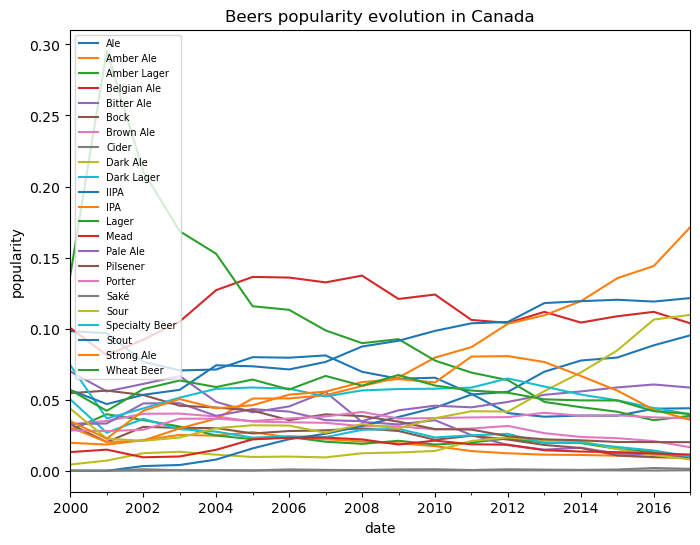

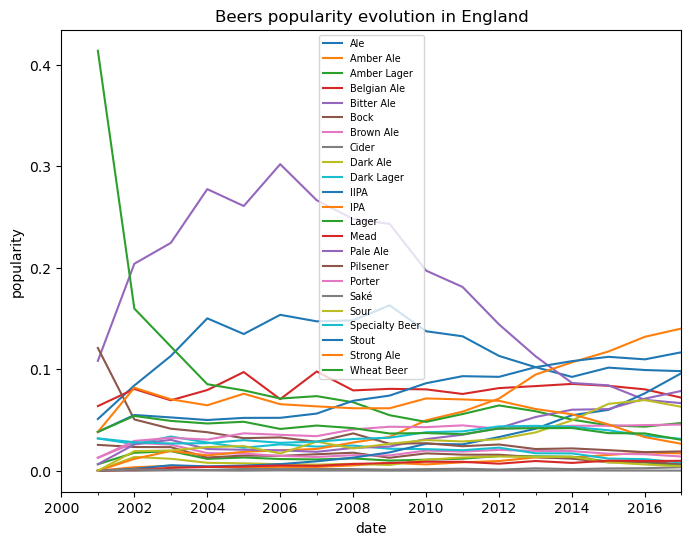

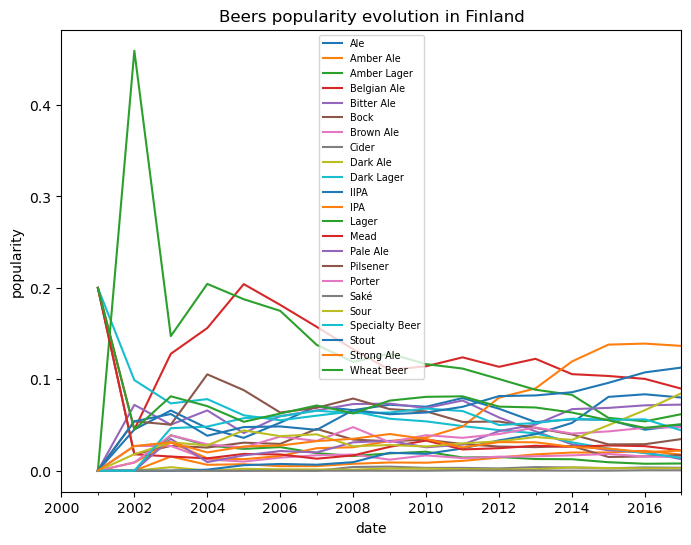

In [60]:
for name in ['Canada', 'England', 'Finland']:
    
    pivot = df_porthos[df_porthos.user_location == name]\
                    .pivot(index = 'date', columns='style', values='counts')\
                    .fillna(0)\
                    .apply(lambda row : row / row.sum(), axis = 1)

    #pivot['year_id'] = list(pivot.index.map(lambda x : x.year - pivot.index.min().year))

    pivot.plot(y  = pivot.columns, 
               title = 'Beers popularity evolution in ' + name, 
               ylabel = 'popularity',
               xlabel = 'date',
               figsize = (8,6))
    
    plt.legend(fontsize=7)
    plt.show()

In [61]:
#set of all countries
countries = [x for x in set(df_porthos.user_location) if x==x]

#to store the Series to facilitate the merging in one Dataframe 
results = []

for country in countries:
    
    pivot = df_porthos[df_porthos.user_location == country]\
                .pivot(index = 'date', columns='style', values='counts')\
                .fillna(0)\
                .apply(lambda row : row / row.sum(), axis = 1)
        
    results.append(pivot.apply(lambda x : yearly_popularity_evolution(x)))

#remove NaN values
res = pd.concat(results, axis = 1).fillna(0)
res.columns = countries
res.style.applymap(highlight_max)

This last table shows us that the variation of popularity, approximated with the slope of a line, isn't the same for each type of beer and for each country. This means that we will study this popularity variation deeper.

For a futher step, we will use a more complex model to better approximate these popularities variations.

Note that the zeros are due to the lack of datas for some countries and some type of beers.